In [45]:
# Google Play Dataset - Preprocessing

# %%
import pandas as pd
df = pd.read_csv('../Google-Playstore.csv')

In [46]:
# %%
from prettytable import PrettyTable
import random
random.seed(5805)

feature_outlook = PrettyTable()
feature_outlook.field_names = ["Feature", "Type", "N/A Count", "N/A Percentage", "Cat/Num", "Unique Count", "Unique Percentage", "Example"]

def judge_cat_num(col):
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        return 'Numerical'
    else:
        return 'Categorical'
    
def check_na_percentage(col):
    ratio = df[col].isna().sum()/len(df[col])
    return f"{ratio:.2%}"

def check_unique_percentage(col):
    ratio = len(df[col].unique())/len(df[col])
    return f"{ratio:.2%}"


for col in df.columns:
    feature_outlook.add_row([col, df[col].dtype, df[col].isna().sum(), check_na_percentage(col), judge_cat_num(col) ,len(df[col].unique()), check_unique_percentage(col), df[col].unique()[random.randint(0, len(df[col].unique())-1)]])
print(feature_outlook)



+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+----------------------------------------------+
|      Feature      |   Type  | N/A Count | N/A Percentage |   Cat/Num   | Unique Count | Unique Percentage |                   Example                    |
+-------------------+---------+-----------+----------------+-------------+--------------+-------------------+----------------------------------------------+
|      App Name     |  object |     5     |     0.00%      | Categorical |   2177944    |       94.16%      |                   駕駛管理                   |
|       App Id      |  object |     0     |     0.00%      | Categorical |   2312944    |      100.00%      | com.mecartec.mejoreshistoriasdeterrorymiedo  |
|      Category     |  object |     0     |     0.00%      | Categorical |      48      |       0.00%       |                 Productivity                 |
|       Rating      | float64 |   22883   |     0.99%      |  

In [47]:
# Numeric features
numeric_describe = PrettyTable()
numeric_describe.field_names = ["Feature", "Mean", "Std", "Min", "25%", "50%", "75%", "Max"]
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        numeric_describe.add_row([col, df[col].mean(), df[col].std(), df[col].min(), df[col].quantile(0.25), df[col].quantile(0.5), df[col].quantile(0.75), df[col].max()])
numeric_describe.float_format = '.3'
print(numeric_describe)
# print(df.describe())

+------------------+------------+--------------+-------+--------+---------+----------+-----------------+
|     Feature      |    Mean    |     Std      |  Min  |  25%   |   50%   |   75%    |       Max       |
+------------------+------------+--------------+-------+--------+---------+----------+-----------------+
|      Rating      |   2.203    |    2.106     | 0.000 | 0.000  |  2.900  |  4.300   |      5.000      |
|   Rating Count   |  2864.839  |  212162.571  | 0.000 | 0.000  |  6.000  |  42.000  |  138557570.000  |
| Minimum Installs | 183445.214 | 15131439.060 | 0.000 | 50.000 | 500.000 | 5000.000 | 10000000000.000 |
| Maximum Installs | 320201.713 | 23554954.887 |   0   | 84.000 | 695.000 | 7354.000 |   12057627016   |
|      Price       |   0.103    |    2.633     | 0.000 | 0.000  |  0.000  |  0.000   |     400.000     |
+------------------+------------+--------------+-------+--------+---------+----------+-----------------+


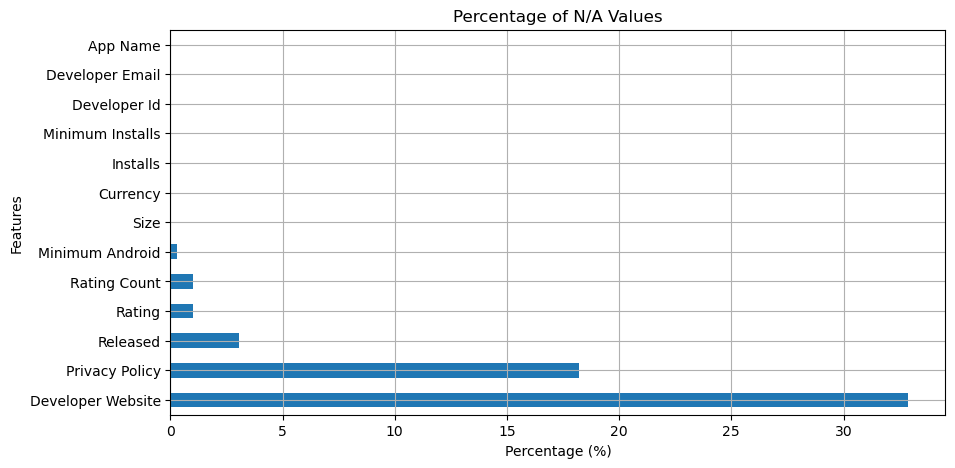

In [48]:
import matplotlib.pyplot as plt
na_feature_percentage = df.isna().sum().sort_values(ascending=False)/len(df) * 100
na_feature_percentage = na_feature_percentage[na_feature_percentage > 0]
plt.figure(figsize=(10, 5))
na_feature_percentage.plot(kind='barh')
plt.xlabel('Percentage (%)')
plt.ylabel('Features')
plt.title('Percentage of N/A Values')
plt.grid()
plt.show()

### Chapter 2 Feature Engineering

In [49]:
# Original shape
print(df.shape)

(2312944, 24)


In [50]:
# Currency distribution
currency_values_count = df['Currency'].value_counts()
print(currency_values_count)

Currency
USD    2311548
XXX       1236
EUR          6
INR          5
GBP          3
CAD          2
VND          1
BRL          1
KRW          1
TRY          1
RUB          1
SGD          1
AUD          1
PKR          1
ZAR          1
Name: count, dtype: int64


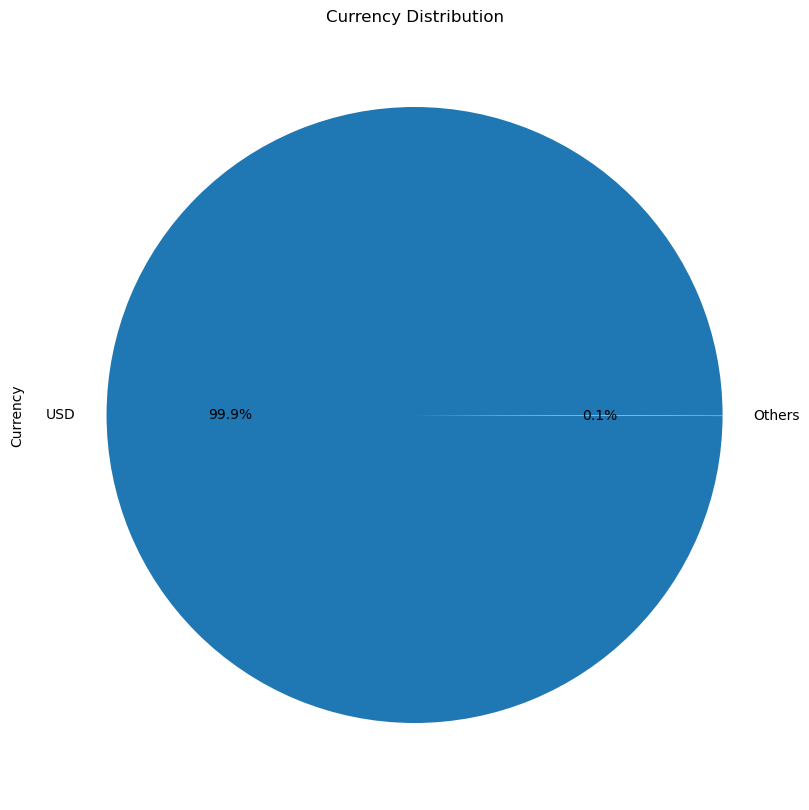

In [51]:
# Currency Distribution - Pie Chart
currency_pie = currency_values_count.head(1)
currency_pie['Others'] = currency_values_count[1:].sum()
currency_pie.plot(kind='pie', figsize=(10, 10), autopct='%1.1f%%', labels=['USD', 'Others'], ylabel='Currency', title='Currency Distribution')
plt.tight_layout()
plt.show()

In [52]:
# Drop all non-USD currency
df['Currency'] = df['Currency'].apply(lambda x: 'USD' if x == 'USD' else 'Others')
df.drop(df[df['Currency'] == 'Others'].index, inplace=True)
print(df.shape)

(2311548, 24)


In [52]:
# Test if installs and min-install are the same


In [53]:
df.drop(['App Id', 'Currency', 'Developer Website', 'Privacy Policy', 'Scraped Time'], axis=1, inplace=True)

In [54]:
print(df.shape)

(2311548, 19)
